# Titanic Classification Competition

## Methodology
1. Load Data
    - Load from memory
    - Shape inspection
    - Delete unuseful features
    - Familiarization of data
2. Exploratory Data Analysis
3. Outlier Detection and Removal
4. Data Preprocessing
    - Check and Visualiza Missing Values
    - Fix DataTypes
    - Imputing Missing Values
5. Feature Engineering
6. Label or One hot encoding
7. Modeling
    - Simple models
        - Logistic Regression
        - SVM
        - KNN
        - Naive Bayes
        - Light XGB
        - XGBoosting
    - Ensembling
8. Making Predictions

# Introduction

This kernel notebook is my first public Kaggle notebook. My aim is to build a much of simple classifiers and see how well it performs. I'll then perform ensembling of the best simple models to option a better prediction if I need to. Lets get started...

In [135]:
import numpy as np 
import pandas as pd 
import seaborn as sns
from matplotlib import pyplot as plt
import warnings
from collections import Counter
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
from sklearn.ensemble import (RandomForestClassifier, 
                              AdaBoostClassifier, 
                              GradientBoostingClassifier,
                              ExtraTreesClassifier, 
                              VotingClassifier)

from lightgbm import LGBMClassifier

# Loading Data and Inspection

In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [3]:
train = pd.read_csv("/kaggle/input/titanic/train.csv")
test = pd.read_csv("/kaggle/input/titanic/test.csv")

In [4]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


## Familiarization Of Dataset

|Feature|Description|
|:-|:-|
|PassengeId|This is just the Identification number given to every passender, I dont think the ID has a determining factor in survival but, it can be used to trace who got a ticke before the other.|
|Pclass|This is for the socio-economic status (SES) 1st ~ Upper; 2nd ~ Middle; 3rd ~ Lower|
|Name|This is just the name of the individual passengers who were on the Titanic at the moment of the crash. I dont think this is a usefull column and I plan on droping it. But, the titles in the name can be usefull so its better to extract a feature from the titles.|
|Sex|This stores the gender of the individual passengers, we need to label encode this since its a binary value. One hot encoding is not compulsory in this process.|
|Age|e is in Years, Fractional if Age less than One (1).If the Age is estimated, it is in the form xx.5|
|sibsp|This stores the family relationship like **Spouce** or **Sibling**|
|Parch|This stores the number of children on parents on board of each individual passenger|
|Ticket|This feature stores the ticke number, this could tell us who bought a ticke before the other|
|Fare|Passenger Fare in British pound|
|Cabin|The cabin in which each individual passenger was in|
|Embarked|Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)|
|Survived|This is the target variable I'll be predicting. Survival (0 = No; 1 = Yes)|

[Reference](http://campus.lakeforest.edu/frank/FILES/MLFfiles/Bio150/Titanic/TitanicMETA.pdf)

# 2. Exploratory Data Analysis (EDA)

## Shape of dataset

In [6]:
print(f" Train shape: {train.shape} \n Test shape: {test.shape}")

 Train shape: (891, 12) 
 Test shape: (418, 11)


## Remove unusefull Features

PassengerId  features are not important, so lets get rid of them

In [7]:
train.drop(['PassengerId'], axis = 1, inplace = True)
test.drop(['PassengerId'], axis = 1, inplace = True)

In [8]:
print(f" Train shape: {train.shape} \n Test shape: {test.shape}")

 Train shape: (891, 11) 
 Test shape: (418, 10)


## Correlation Between Numberic Features and Survival

In [9]:
corr = train.corr()
corr_index = corr.index
corr_index

Index(['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare'], dtype='object')

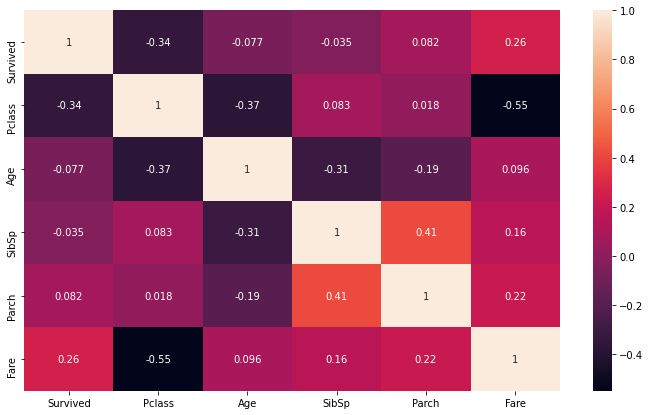

In [10]:
plt.figure(figsize = (12, 7))
sns.heatmap(corr, annot = True)
plt.show()

### Simple Interpretation

A postive correlation means when one value increases the other also increases for bivariate data.

#### Fare and Parch

These bivariate data has a positive correlation Parch is the total number of children or parent on board for each individual meaning. This makes sense cause, if you were to travel with your family, you will probably carry more laguage hence more on your fare.

Age and Survived have a negative correlation, meaning as one goes up the other goes down.

[Reference](https://www.investopedia.com/terms/p/positive-correlation.asp)

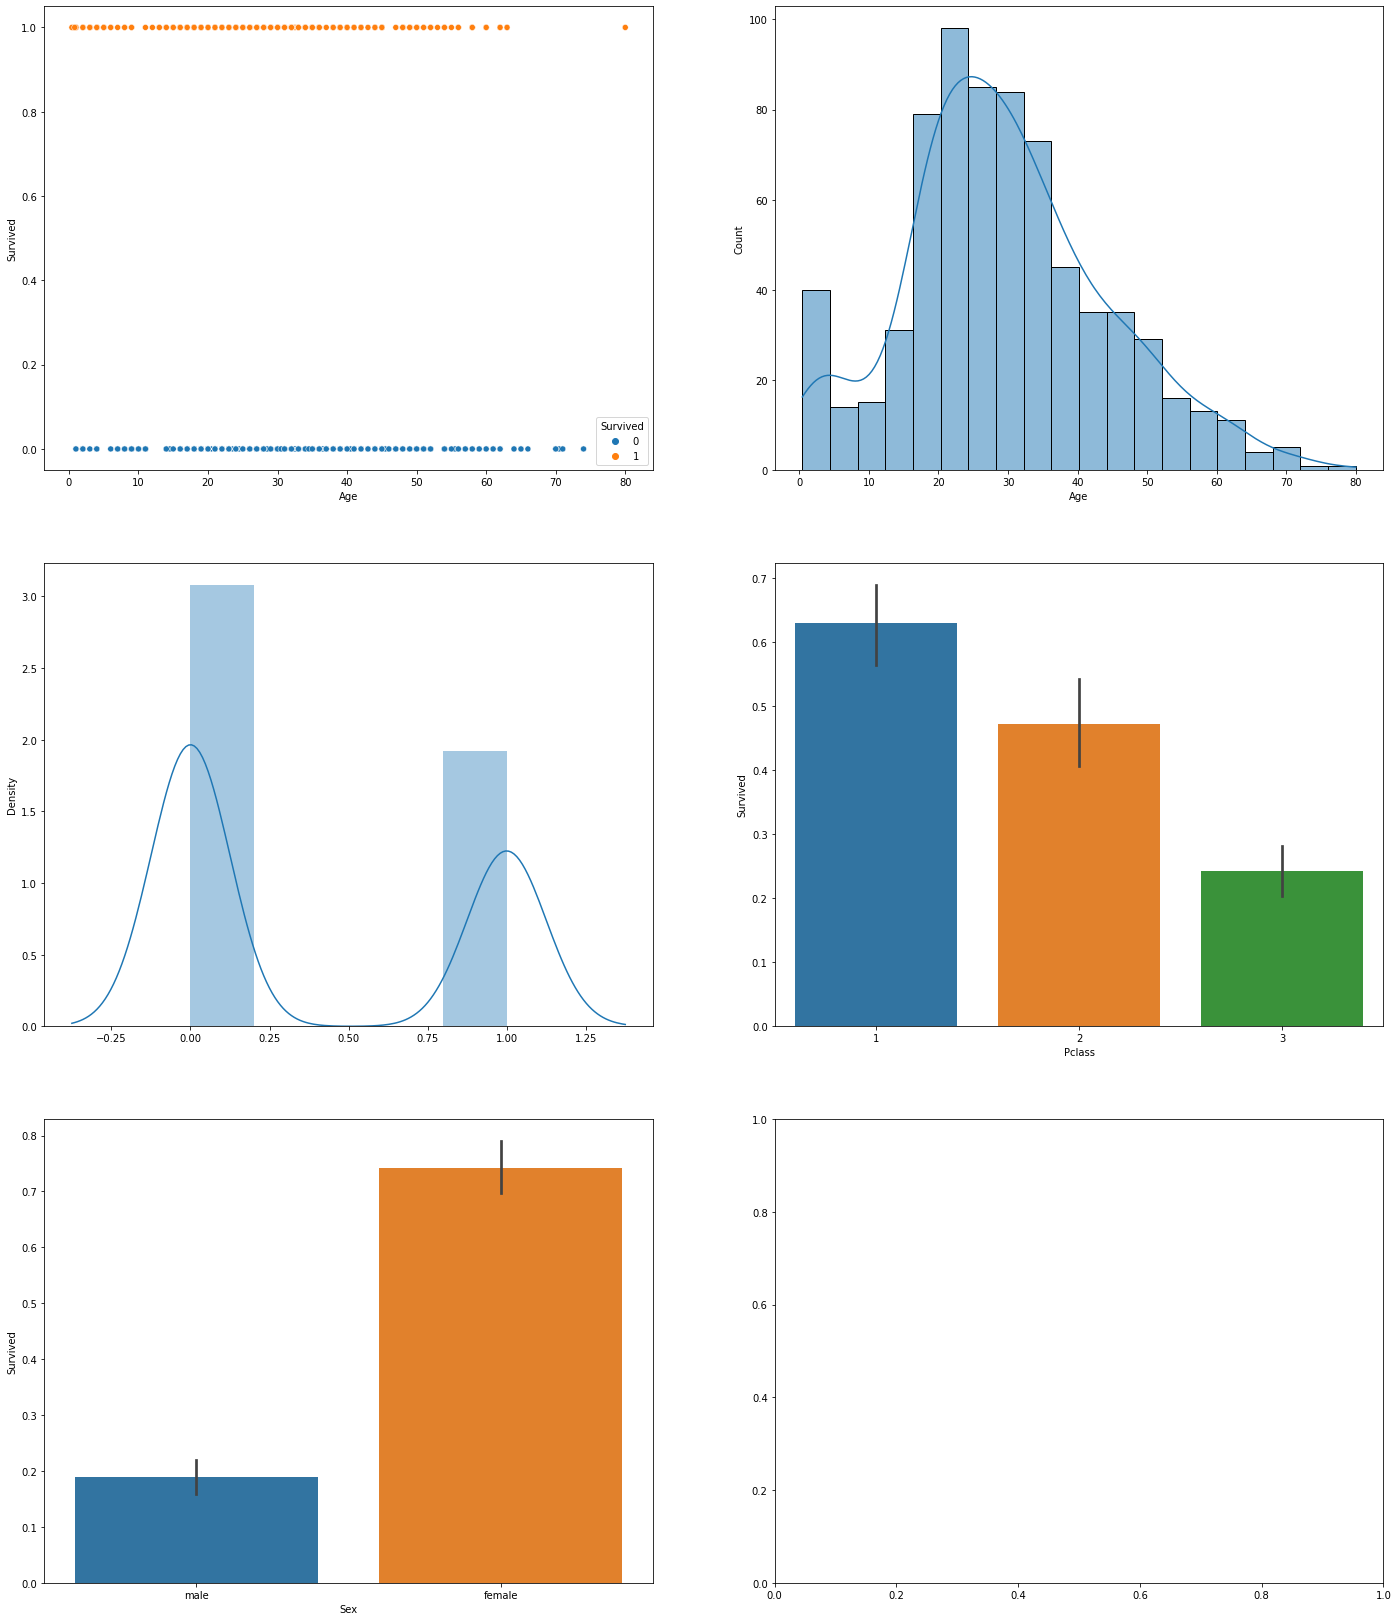

In [11]:
# ignore the warnings
warnings.filterwarnings("ignore")

fig, axes = plt.subplots(3, 2, figsize = (24, 29))
sns.scatterplot(ax = axes[0, 0], x = 'Age', y = 'Survived', data = train, hue = 'Survived')
sns.histplot(ax = axes[0, 1], x = train['Age'], kde = True)
sns.distplot(ax = axes[1, 0], x = train['Survived'])
sns.barplot(ax = axes[1, 1], x = "Pclass", y = 'Survived', data = train)
sns.barplot(ax = axes[2, 0], x = "Sex", y = 'Survived', data = train)
plt.show()

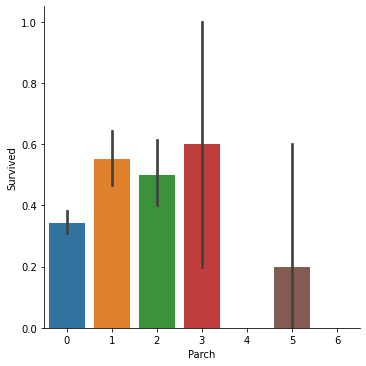

In [12]:
sns.catplot(ax = axes[2, 0], x = "Parch", y = 'Survived', data = train, kind = "bar")

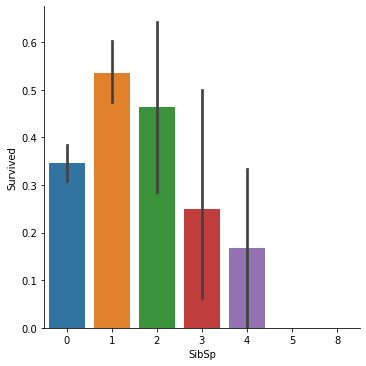

In [13]:
sns.catplot(y = 'Survived', x = 'SibSp',data = train, kind="bar")

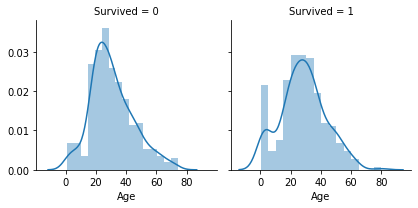

In [14]:
graph = sns.FacetGrid(train, col='Survived')
graph = graph.map(sns.distplot, "Age")

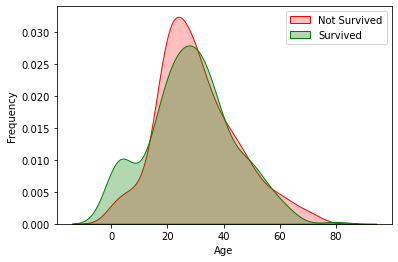

In [15]:
graph = sns.kdeplot(train["Age"][(train["Survived"] == 0) & (train["Age"].notnull())], color="Red", shade = True)
graph = sns.kdeplot(train["Age"][(train["Survived"] == 1) & (train["Age"].notnull())], ax =graph, color="Green", shade= True, alpha = 0.3)
graph.set_xlabel("Age")
graph.set_ylabel("Frequency")
graph = graph.legend(["Not Survived","Survived"])

- This shows that you are more likely to not survive if your age is around 25-35. 

- On the other hand Children are more likely to survive compared to not survive around ages 0-13

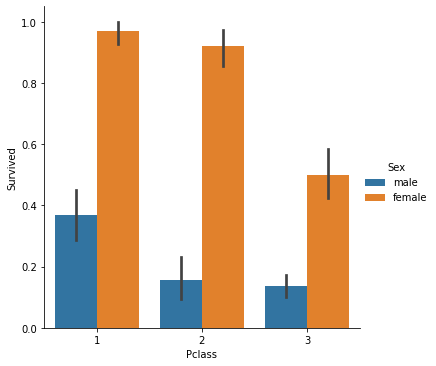

In [16]:
sns.catplot(ax = axes[2, 1], x = 'Pclass', y = 'Survived', hue = 'Sex', data = train, kind = 'bar')

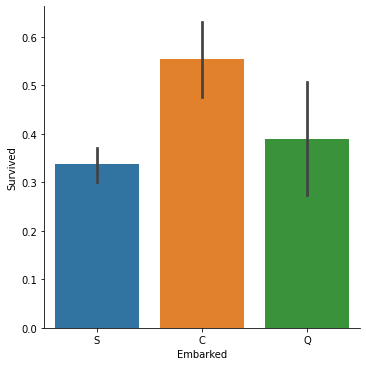

In [17]:
sns.catplot(x = "Embarked", y = "Survived", kind = 'bar', data = train)

Most passengers from town C are more survived but why is that? lets find out with the next plot

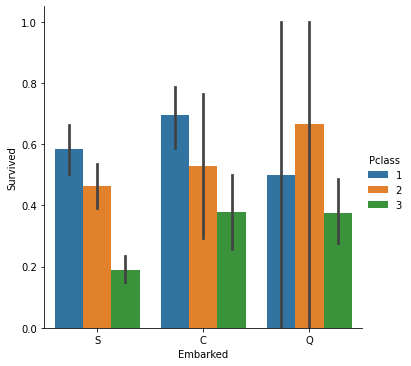

In [18]:
sns.catplot(x = "Embarked", y = "Survived", kind = 'bar',  hue = 'Pclass', data = train)

Okay, we can see that most first class passenger came from town C and first class passengers are more likely to survive.

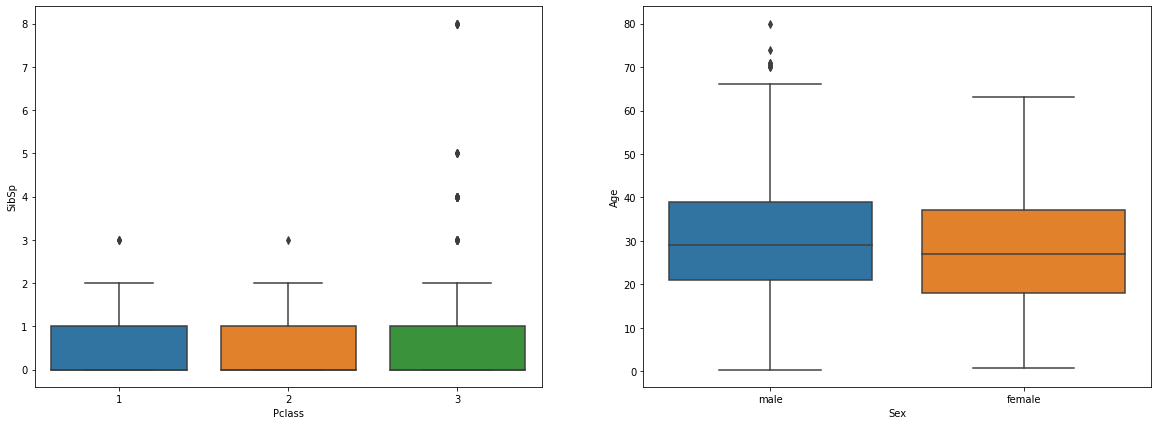

In [19]:
fig, axes = plt.subplots(1, 2, figsize = (20, 7))
sns.boxplot(ax = axes[0], x = "Pclass", y ="SibSp", data = train)
sns.boxplot(ax = axes[1], x = "Sex", y = "Age", data = train)
plt.show()

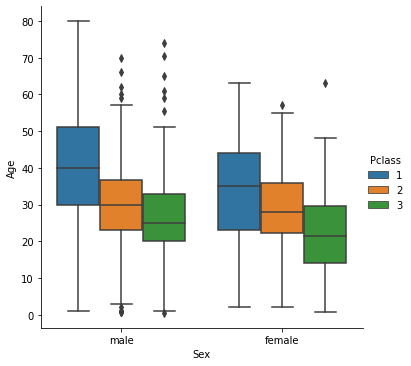

In [20]:
sns.catplot(x = "Sex",  y = "Age", data = train, hue = "Pclass", kind = "box")

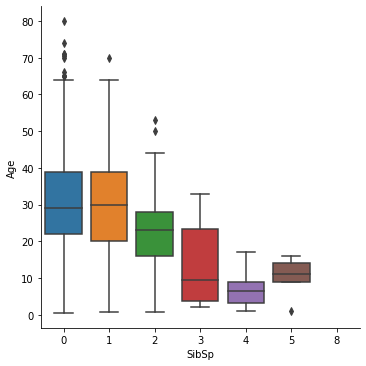

In [21]:
sns.catplot(x = "SibSp",  y = "Age", data = train, kind = "box")

Most adults from 20-30 were traveling alone, while children had thier siblings or Sp for adulsts

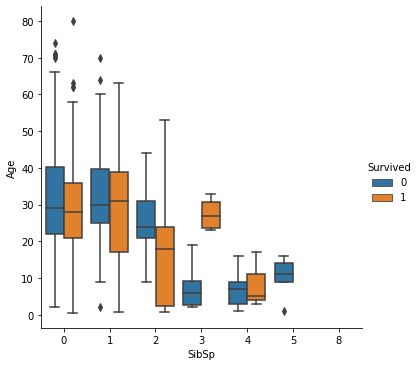

In [22]:
sns.catplot(x = "SibSp",  y = "Age", data = train, kind = "box", hue = "Survived")

### Unique Valus for each Categorical feature

In [23]:
for col in train.select_dtypes(include = ['category', 'object']):
    print(f"Unique values for {col}: \n\t {train[col].unique()}")

Unique values for Name: 
	 ['Braund, Mr. Owen Harris'
 'Cumings, Mrs. John Bradley (Florence Briggs Thayer)'
 'Heikkinen, Miss. Laina' 'Futrelle, Mrs. Jacques Heath (Lily May Peel)'
 'Allen, Mr. William Henry' 'Moran, Mr. James' 'McCarthy, Mr. Timothy J'
 'Palsson, Master. Gosta Leonard'
 'Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)'
 'Nasser, Mrs. Nicholas (Adele Achem)' 'Sandstrom, Miss. Marguerite Rut'
 'Bonnell, Miss. Elizabeth' 'Saundercock, Mr. William Henry'
 'Andersson, Mr. Anders Johan' 'Vestrom, Miss. Hulda Amanda Adolfina'
 'Hewlett, Mrs. (Mary D Kingcome) ' 'Rice, Master. Eugene'
 'Williams, Mr. Charles Eugene'
 'Vander Planke, Mrs. Julius (Emelia Maria Vandemoortele)'
 'Masselmani, Mrs. Fatima' 'Fynney, Mr. Joseph J' 'Beesley, Mr. Lawrence'
 'McGowan, Miss. Anna "Annie"' 'Sloper, Mr. William Thompson'
 'Palsson, Miss. Torborg Danira'
 'Asplund, Mrs. Carl Oscar (Selma Augusta Emilia Johansson)'
 'Emir, Mr. Farred Chehab' 'Fortune, Mr. Charles Alexander'
 'O\'Dwyer, Mi

From the unique values, you can spot some missing values, lets go ahead later on and deal with missing values.

First lets remove the outliers from the training dataset. 

## OUtlier Detection and Removal

For this, we'll use the standart IQR technique also known as Tukey Method. Also we'll only perform outlier detection and removal for numeric features

(599, 11)

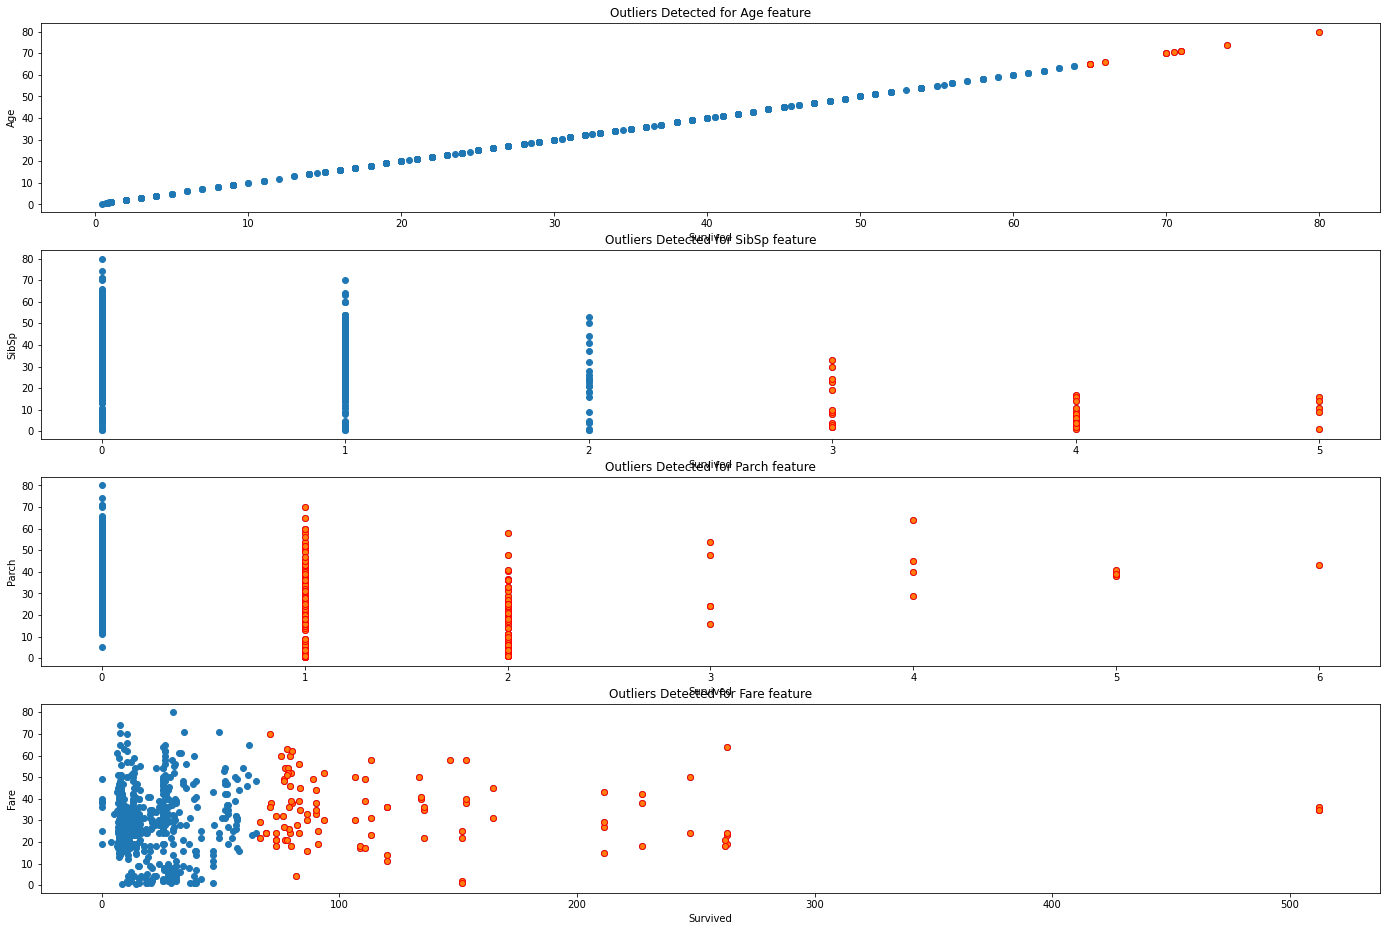

In [24]:
outlier_index = []

# cols = train.select_dtypes(exclude = ['category', 'object']).columns
cols =  ["Age","SibSp","Parch","Fare"]
ncols = 1
nrows = int(len(cols)/ncols)

fig, axes = plt.subplots(nrows, ncols, figsize = (24, nrows*4))

for row, col in enumerate(cols):

    Q1 = train[col].quantile(.25)
    Q3 = train[col].quantile(.75)
    IQR = Q3 - Q1
    lowe_limit = Q1 - (1.5 * IQR)
    upper_limit = Q3 + (1.5 * IQR)
    outliers = train[(train[col] < lowe_limit) | (train[col] > upper_limit)]
    
    axes[row].scatter(y = train['Age'], x = train[col])
    axes[row].scatter(y = outliers['Age'], x = outliers[col], marker = 'o', edgecolor = 'red')
    axes[row].set_xlabel("Survived")
    axes[row].set_ylabel(str(col))
    axes[row].set_title(f"Outliers Detected for {str(col)} feature")
    
    
    outlier_index += outliers.index.tolist()

# selecting observations with 3 counts to reduce data loss
# https://www.guru99.com/python-counter-collections-example.html
counter = Counter(outlier_index)
unique_outliers = list(k for k, v in counter.items() if k > 3)

train = train.drop(unique_outliers)
train = train.reset_index(drop = True)
train.shape

# Data Preprocessing

In [25]:
y_train = train['Survived']
train.drop("Survived", axis = 1, inplace = True)
all_data = pd.concat([train, test]).reset_index(drop = True)

In [26]:
y_train.head()

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

## Check For Missing Values

In [27]:
def check_missing_values(df):
    col_na = df.columns[df.isnull().any()]
    col_na_df = df[col_na].isnull().sum()
    percentage_df = (df.isnull().sum() / len(df)) * 100
    percentage_col = (df[col_na].isnull().sum() / len(df)) * 100
     
    return percentage_df, pd.DataFrame({"Missing Value Count" : col_na_df, "Percentage of NaN values" : percentage_col})
    

In [28]:
percentage_df, percentage_col = check_missing_values(all_data)

In [29]:
percentage_df

Pclass       0.000000
Name         0.000000
Sex          0.000000
Age         23.107178
SibSp        0.000000
Parch        0.000000
Ticket       0.000000
Fare         0.098328
Cabin       82.399213
Embarked     0.000000
dtype: float64

In [30]:
percentage_col

,Missing Value Count,Percentage of NaN values
Age,235,23.107178
Fare,1,0.098328
Cabin,838,82.399213


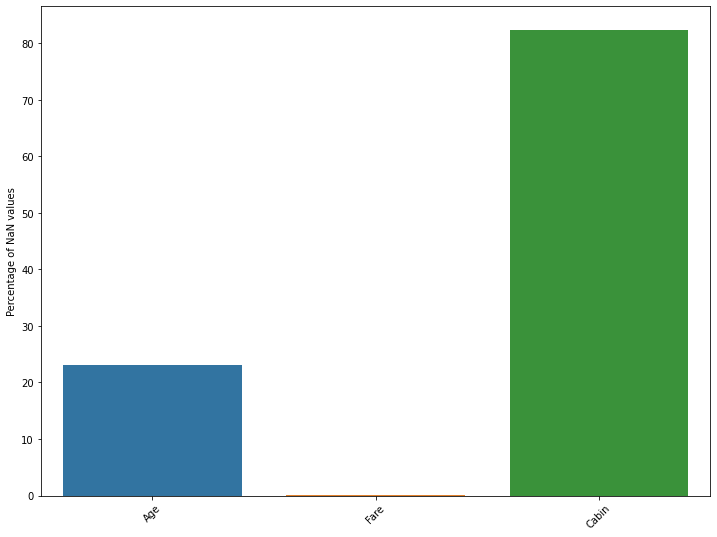

In [31]:
plt.figure(figsize = (12, 9))
sns.barplot(x = percentage_col.index, y = "Percentage of NaN values",  data = percentage_col)
plt.xticks(rotation = 45)
plt.title = "Missing Values Visualization"
plt.show()

From the above data frame, we can see that the Cabin, Fare and Age features have missing values. Cabin has the most missing values in all.

Lets replace missing cabins with X, for age, we can use mean for fare we can decide to drop it since its only one or just use the mean. I'll use the mean in this case.

In [32]:
all_data['Cabin'].replace({np.nan : "X"}, inplace = True)
all_data['Cabin'].head()

0       X
1     C85
2       X
3    C123
4       X
Name: Cabin, dtype: object

In [33]:
all_data['Age'].replace({np.nan : all_data['Age'].mean()}, inplace = True)

In [34]:
all_data['Fare'].fillna(method = 'bfill', inplace = True)

In [35]:
percentage_df, percentage_col = check_missing_values(all_data)

In [36]:
percentage_df

Pclass      0.0
Name        0.0
Sex         0.0
Age         0.0
SibSp       0.0
Parch       0.0
Ticket      0.0
Fare        0.0
Cabin       0.0
Embarked    0.0
dtype: float64

In [37]:
percentage_col

,Missing Value Count,Percentage of NaN values


<AxesSubplot:>

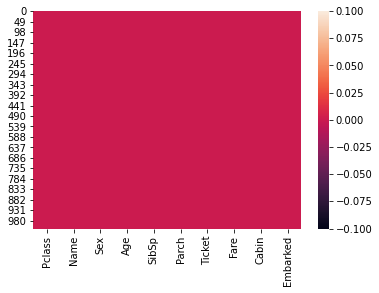

In [38]:
sns.heatmap(all_data.isnull())
# confirming we dont have missing values

### Checking Data Types

In [39]:
all_data.dtypes

Pclass        int64
Name         object
Sex          object
Age         float64
SibSp         int64
Parch         int64
Ticket       object
Fare        float64
Cabin        object
Embarked     object
dtype: object

Looks like we have all the Features with thier right data types, great! You can confirm from the dataframe output below.

In [40]:
all_data.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,X,S
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,X,S
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,X,S


# Feature Engineering


The ``Name`` feature can be of use to us. It contains the title of an individual passenger. Lets see whow it relates to survivability. First we need to filter it out. Lets get started...

In [41]:
titles = [title[1][:-1] for title in all_data['Name'].str.split(" ")]
titles[:5]

['Mr', 'Mrs', 'Miss', 'Mrs', 'Mr']

In [42]:
all_data['Title'] = titles
all_data.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,X,S,Mr
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,X,S,Miss
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs
4,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,X,S,Mr


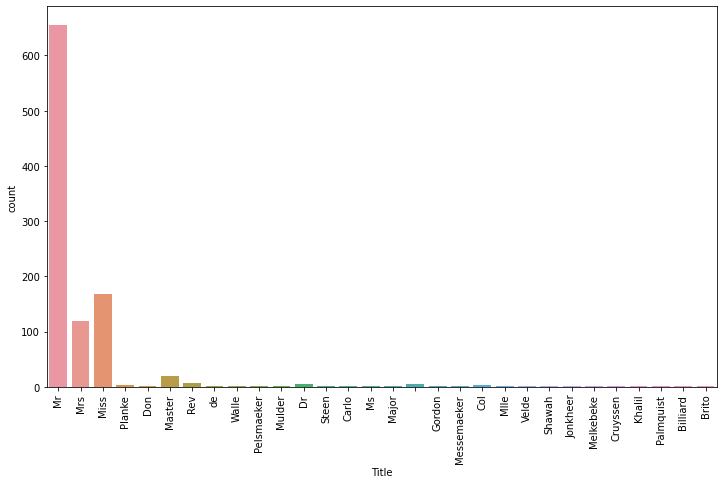

In [43]:
plt.figure(figsize = (12, 7))
sns.countplot(x = all_data["Title"])
plt.xticks(rotation = 90)
plt.show()

Some of the title in here are not common, lets group those to avoid model complexity.

In [44]:
unwanted_titles = [title for title in all_data['Title'].unique() if title not in ['Mr', 'Mrs', 'Miss', 'Dr', 'Ms']]
unwanted_titles[:5]

['Planke', 'Don', 'Master', 'Rev', 'de']

In [45]:
all_data['Title'].replace(to_replace = unwanted_titles, value = ['unpopular']*len(unwanted_titles), inplace = True)
all_data['Title'].unique()

array(['Mr', 'Mrs', 'Miss', 'unpopular', 'Dr', 'Ms'], dtype=object)

<AxesSubplot:xlabel='Title', ylabel='Survived'>

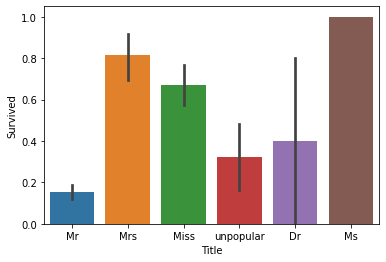

In [46]:
sns.barplot(x = all_data[:len(train)]['Title'], y = y_train)

### Relationship and Care

From the data analysis and visualization, its clear that:

1. Survival probability for people with 3 children or parent(s) on board was the most highest.
2. At the same time, people with 3 siblings or spouce have the second lowest survival probability of about 20%

This shows a relationship between total number of relatives or spouce on board and survival probability. Lets great a feature to depict this relationship. Lets add total ``Parch`` and ``SibSp`` together for each passenger to create a feature called ``FamilySize``

In [47]:
all_data['FamilySize'] = all_data['Parch'] + all_data['SibSp']
all_data.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,FamilySize
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,X,S,Mr,1
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,1
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,X,S,Miss,0
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,1
4,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,X,S,Mr,0


<AxesSubplot:xlabel='FamilySize', ylabel='Survived'>

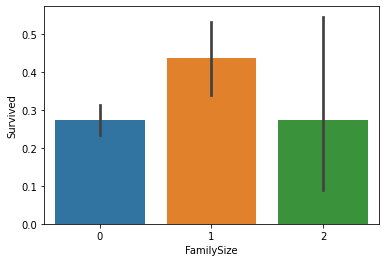

In [48]:
sns.barplot(x = all_data[:len(train)]['FamilySize'], y = y_train)

## Fixing Data Types

Lets convert object types to categorical types then one hot encode them.

In [52]:
all_data.dtypes

Pclass          int64
Sex            object
Age           float64
SibSp           int64
Parch           int64
Fare          float64
Cabin          object
Embarked       object
Title          object
FamilySize      int64
dtype: object

In [53]:
for col in all_data.select_dtypes(include = ['object']):
    all_data[col] = all_data[col].astype("category")

In [54]:
all_data.dtypes

Pclass           int64
Sex           category
Age            float64
SibSp            int64
Parch            int64
Fare           float64
Cabin         category
Embarked      category
Title         category
FamilySize       int64
dtype: object

#### Drop the ``Ticket`` and Name column

I dont find this column important and think I should just drop it.

For the ``Name`` column, we have already extracted a feature from it so we can drop it as well.

In [50]:
all_data.drop(['Name', 'Ticket'], axis = 1, inplace = True)

In [51]:
all_data.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Title,FamilySize
0,3,male,22.0,1,0,7.2500,X,S,Mr,1
1,1,female,38.0,1,0,71.2833,C85,C,Mrs,1
2,3,female,26.0,0,0,7.9250,X,S,Miss,0
3,1,female,35.0,1,0,53.1000,C123,S,Mrs,1
4,3,male,35.0,0,0,8.0500,X,S,Mr,0


# One Hot Encoding

For one hot encoding, I'll encode the categoricall features: 

- Sex
- Cabin
- Embarked
- Title

In [55]:
all_data = pd.get_dummies(all_data, columns = ['Sex'], prefix = "Sex")
all_data = pd.get_dummies(all_data, columns = ['Title'], prefix = "Tit")
all_data = pd.get_dummies(all_data, columns = ['Cabin'], prefix = "Cab")
all_data = pd.get_dummies(all_data, columns = ['Embarked'], prefix = "Emb")

In [56]:
all_data.head()

,Pclass,Age,SibSp,Parch,Fare,FamilySize,Sex_female,Sex_male,Tit_Dr,Tit_Miss,...,Cab_F2,Cab_F33,Cab_F38,Cab_F4,Cab_G6,Cab_T,Cab_X,Emb_C,Emb_Q,Emb_S
0,3,22.0,1,0,7.2500,1,0,1,0,0,...,0,0,0,0,0,0,1,0,0,1
1,1,38.0,1,0,71.2833,1,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,26.0,0,0,7.9250,0,1,0,0,1,...,0,0,0,0,0,0,1,0,0,1
3,1,35.0,1,0,53.1000,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,3,35.0,0,0,8.0500,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,1


In [60]:
scaler = MinMaxScaler()

In [64]:
all_data['Age'] = scaler.fit_transform(all_data['Age'].values.reshape(-1, 1))
all_data['Fare'] = scaler.fit_transform(all_data['Fare'].values.reshape(-1, 1))

In [65]:
all_data.head()

,Pclass,Age,SibSp,Parch,Fare,FamilySize,Sex_female,Sex_male,Tit_Dr,Tit_Miss,...,Cab_F2,Cab_F33,Cab_F38,Cab_F4,Cab_G6,Cab_T,Cab_X,Emb_C,Emb_Q,Emb_S
0,3,0.287881,1,0,0.014151,1,0,1,0,0,...,0,0,0,0,0,0,1,0,0,1
1,1,0.498879,1,0,0.139136,1,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,0.340630,0,0,0.015469,0,1,0,0,1,...,0,0,0,0,0,0,1,0,0,1
3,1,0.459317,1,0,0.103644,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,3,0.459317,0,0,0.015713,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,1


In [67]:
print(f"Age max {all_data['Age'].max()}")
print(f"Fare max {all_data['Fare'].max()}")

Age max 1.0
Fare max 1.0


# Modeling 

Finaly we are ready to do some modeling :)

But before that, lets fo ahead and uncombine the training and testing data since we combined them earlier.

In [78]:
train_data =  all_data[:len(train)]
test_data = all_data[len(train):]

In [82]:
print(f"Train data: {train_data.shape}")
print(f"test data: {test_data.shape}")
print(f"Original Test data: {test.shape}")
print(f"Y_train: {y_train.shape}")

Train data: (599, 151)
test data: (418, 151)
Original Test data: (418, 10)
Y_train: (599,)


# Base Models

I will use the following base or simple models

- Logistic Regression
- SVC
- Decision Tree
- Random Forest
- Gradient Descent
- K-Nearest Neighbors
- Linear Discriminant Analysis
- MLP Classifier
- Extra Trees Classifier
- LGBM Classifier

## Simple Models

In [155]:
log_reg = LogisticRegression(penalty='l2',C = 10 ,random_state = 20)
svc = svm = SVC(random_state = 20)
decision_tree = DecisionTreeClassifier(random_state=20)
rand_forest = RandomForestClassifier(random_state=20)
grad_desc = GradientBoostingClassifier(random_state=20)
knn = KNeighborsClassifier()
Lin_Disc = LinearDiscriminantAnalysis()
mlp = MLPClassifier(random_state=20)
xtra = ExtraTreesClassifier(random_state=20)
lgb_classifier = LGBMClassifier()
adaboost = AdaBoostClassifier(DecisionTreeClassifier(random_state=20),random_state=20 ,learning_rate=0.1)

In [156]:
models = [log_reg, svc, decision_tree, rand_forest, grad_desc, knn, Lin_Disc, mlp, xtra, lgb_classifier, adaboost]
models_name = ['log_reg', 'svc', 'decision_tree', 'rand_forest', 'grad_desc', 'knn', 
               'Lin_Disc', 'mlp', 'xtra', 'lgb_classifier', 'adaboost']

#### Run all simple models

In [157]:
kfold = StratifiedKFold(n_splits = 5)

In [158]:
def model_perf(model, X_train, y_train):
    cv_scores = cross_val_score(model, X = X_train, y = y_train, n_jobs = 4, cv = kfold, scoring = 'accuracy')
    mean = cv_scores.mean()
    std = cv_scores.std()
    
    return mean, std

In [159]:
def run_all(models, models_name):
    
    models_mean = []
    models_std = []
    
    for model in models:
        mean, std = model_perf(model, train_data, y_train)
        models_mean.append(mean)
        models_std.append(std)
        
    results = pd.DataFrame({"Model_Name" : models_name, "Mean_score" : models_mean, "STD_score" : models_std})
    
    return results

In [160]:
results = run_all(models, models_name)

In [161]:
results

,Model_Name,Mean_score,STD_score
0,log_reg,0.813053,0.010811
1,svc,0.809706,0.009272
2,decision_tree,0.734510,0.029048
3,rand_forest,0.771303,0.017727
4,grad_desc,0.806331,0.019421
5,knn,0.792983,0.029561
6,Lin_Disc,0.799650,0.015118
7,mlp,0.803053,0.015817
8,xtra,0.764580,0.013823
9,lgb_classifier,0.791345,0.029168


In [162]:
def plot_perf(results):
    graph = sns.barplot(x = results['Mean_score'], y = results['Model_Name'])
    graph.set_title("Simple Models Cross Validation Performance in Accuracy")
    graph.set_xlabel("Accuracy Score")

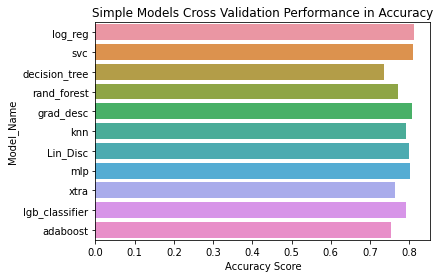

In [163]:
plot_perf(results)

The models I choose to use are:

- SVC
- GradientBoosting
- LGBClassifier
- AdaBoost
- RandomForest

## Hyperparameter Tunning Of The Best Models

In [178]:
models_grid = {
    "SVC" : {
        "model" : SVC(),
        "parameters" : {
            'C': [0.1, 1, 10, 100, 267, 1000], 
            'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
            'kernel': ['rbf']
        }
    },
    
    "GradientBoosting" : {
        "model" : GradientBoostingClassifier(),
        "parameters" : {
            'loss' : ["deviance"],
            'n_estimators' : [100,200,300],
            'learning_rate': [0.1, 0.05, 0.01],
            'max_depth': [4, 8],
            'min_samples_leaf': [100,150],
            'max_features': [0.3, 0.1] 
        }
    },
    
    "LGBClassifier" : {
        "model" : LGBMClassifier(),
        "parameters" : {
            "boosting_type" : ["gbdt", "dart", "goss", "rf"],
            "num_leaves" : [5, 20, 30, 40, 100],
            "max_depth" : [0, 1, 5, 10, 20],
            "learning_rate" : [0.01, 0.001, 0.1],
            "n_estimators" : [100, 150, 200, 300]
        }
    },
    
    "AdaBoost" : {
        "model" : AdaBoostClassifier(DecisionTreeClassifier()),
        "parameters" : {
            "base_estimator__criterion" : ["gini", "entropy"],
            "base_estimator__splitter" :   ["best", "random"],
            "algorithm" : ["SAMME","SAMME.R"],
            "n_estimators" :[1,2],
            "learning_rate":  [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3,1.5]
        }
    },
    
    "RandomForest" : {
        "model" : RandomForestClassifier(),
        "parameters" : {
            "max_depth": [None],
            "max_features": [1, 3, 10],
            "min_samples_split": [2, 3, 10],
            "min_samples_leaf": [1, 3, 10],
            "bootstrap": [False, True],
            "n_estimators" :[100,300],
            "criterion": ["gini"]
        }
    }
}

In [179]:
scores = []
params = []
for estimator_info in models_grid.keys():
    estimator = models_grid[estimator_info]
    grid_srch = GridSearchCV(estimator = estimator['model'], param_grid = estimator['parameters'], 
                             scoring = 'accuracy', n_jobs = 4, cv = kfold)
    grid_srch.fit(train_data, y_train)
    scores.append(grid_srch.best_score_)
    params.append(grid_srch.best_params_)

In [183]:
performace_results = pd.DataFrame({"Model_Name" : models_grid.keys(), "Model_score" : scores, "Model_params" : params})

In [184]:
performace_results

,Model_Name,Model_score,Model_params
0,SVC,0.814692,"{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}"
1,GradientBoosting,0.819720,"{'learning_rate': 0.01, 'loss': 'deviance', 'm..."
2,LGBClassifier,0.818053,"{'boosting_type': 'goss', 'learning_rate': 0.1..."
3,AdaBoost,0.774594,"{'algorithm': 'SAMME.R', 'base_estimator__crit..."
4,RandomForest,0.818053,"{'bootstrap': True, 'criterion': 'gini', 'max_..."


### Ensemble Simple Models

In [ ]:
voting_classifier = VotingClassifier(estimators = [('svc', )])